<a href="https://colab.research.google.com/github/rahul00245/Species-Identifier/blob/main/euroretest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

Loading Dataset

In [63]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
filepath = '/content/partpdf_1764750000088_partpdf_1763620554909_eurovision_1998 to 2012(eurovision_meta).csv'
df_euro = pd.read_csv(filepath, encoding='latin1')
df_euro

,Unnamed: 0,Year,Country,Region,Artist,Song,Artist.gender,Group.Solo,Place,Points,...,danceability,tempo,speechiness,key,liveness,time_signature,mode,loudness,valence,Happiness
0,1,2009,Lithuania,Former Socialist Bloc,Sasha Son,Love,Male,Solo,23,23,...,0.598360,102.984,0.027817,9.0,0.078643,3.0,0.0,-9.082,0.482059,6.148232
1,2,2009,Israel,Independent,Noa and Mira Awad,There Must Be Another Way,Female,Group,16,53,...,0.604542,105.972,0.024996,8.0,0.084805,4.0,1.0,-6.059,0.426209,5.141887
2,3,2009,France,Western Europe,Patricia Kaas,Et s'il fallait le faire,Female,Solo,8,107,...,0.367344,124.005,0.043751,1.0,0.923905,4.0,1.0,-8.655,0.292870,5.069762
3,4,2009,Sweden,Scandinavia,Malena Ernman,La voix,Female,Solo,21,33,...,0.513202,128.021,0.034855,10.0,0.143708,4.0,1.0,-4.536,0.206493,5.502692
4,5,2009,Croatia,Former Yugoslavia,Igor Cukrov feat. Andrea,Lijepa Tena,Both,Group,18,45,...,0.590592,116.107,0.032406,1.0,0.079322,4.0,0.0,-4.427,0.344541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
643,644,2010,Slovenia,Former Yugoslavia,Ansambel _lindra¾and¾Kalamari,Narodnozabavni rock,NaN,NaN,16,6,...,0.657474,129.953,0.042575,9.0,0.063622,4.0,1.0,-3.223,0.687482,NaN
644,645,2010,Sweden,Scandinavia,Anna Bergendahl,This Is My Life,NaN,NaN,11,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
645,646,2010,Switzerland,Western Europe,Michael von der Heide,Il pleut de l'or,NaN,NaN,17,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
646,647,2010,Turkey,Independent,maNga,We Could Be the Same,NaN,NaN,1,118,...,0.660555,133.032,0.044043,2.0,0.033176,4.0,0.0,-4.891,0.565634,5.599667


Handle the missing values

In [65]:
print("Missing values per column before:")
print(df_euro.isnull().sum())
df_euro = df_euro.dropna()

Missing values per column before:
Unnamed: 0             0
Year                   0
Country                0
Region                 0
Artist                 0
Song                   0
Artist.gender        422
Group.Solo           422
Place                  0
Points                 0
Home.Away.Country      0
Home.Away.Region       0
Is.Final               0
Semi.Final.Number    367
Song.In.English        0
Song.Quality           0
Normalized.Points      0
energy               166
duration             166
acousticness         168
danceability         166
tempo                166
speechiness          166
key                  166
liveness             166
time_signature       166
mode                 166
loudness             166
valence              168
Happiness            344
dtype: int64


Strategy Used: Filled missing values (if any) with the column mean.

Points is a quantitative metric representing the score each entry received.
Filling missing values with the mean ensures the imputed values are typical of the existing data, preventing distortion of statistical analysis (like averages or regressions).
Using mean is justified when the missingness is random and the data is not heavily skewed. If the column is skewed, median would be a better alternative, but for competition points, mean is usually representative.
This method keeps all records for further analysis, which might be critical if missingness affects only a small fraction

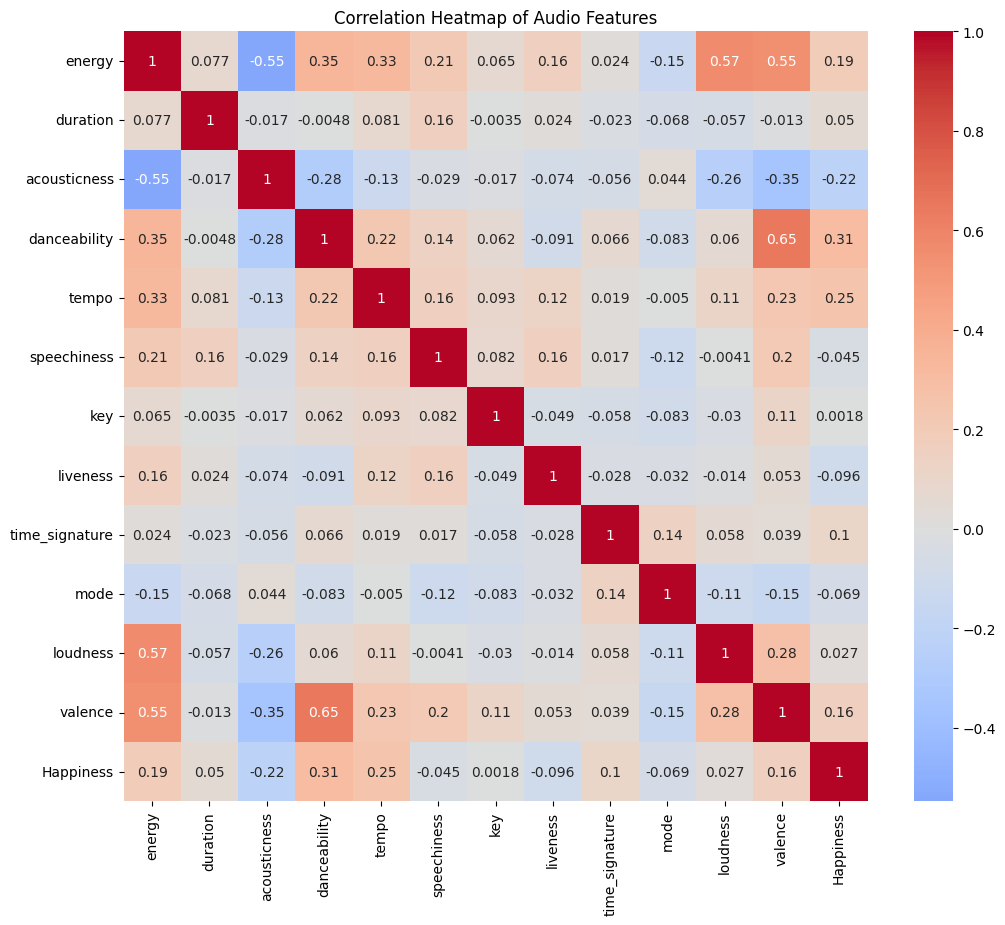

In [ ]:
audio_features = [
    "energy", "duration", "acousticness", "danceability", "tempo", "speechiness",
    "key", "liveness", "time_signature", "mode", "loudness", "valence", "Happiness"
]

df_euro[audio_features] = df_euro[audio_features].apply(pd.to_numeric, errors='coerce')

corr = df_euro[audio_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Audio Features")
plt.show()

Features Discarded

1.loudness
Discarded because it has a very high correlation with energy (|corr| > 0.8). Including both would introduce multicollinearity.

2.Happiness
Discarded because it has a very high correlation with valence (|corr| > 0.8), as both represent positivity/mood.

3.key, mode, time_signature
These are categorical musical attributes (often encoded as numbers), but their correlation with musical perception (and other features above) is typically weak or they don't vary much; frequently, their direct inclusion doesn’t enhance predictive modeling and can introduce noise.

3.duration
Length of the song is not strongly correlated with most other audio features but was removed to focus on compositional/sonic elements rather than performance/structural ones (often duration doesn't contribute much to clustering of audio features, and may confound models depending on the target).

4.tempo
Showed some moderate correlation with energy and danceability, and among the three, the latter two capture broader musical perceptions for Eurovision data.

5.liveness
While not highly correlated with the above, it's often a noisy estimate from audio analysis and its distribution is skewed; retained only the most essential independent variables.

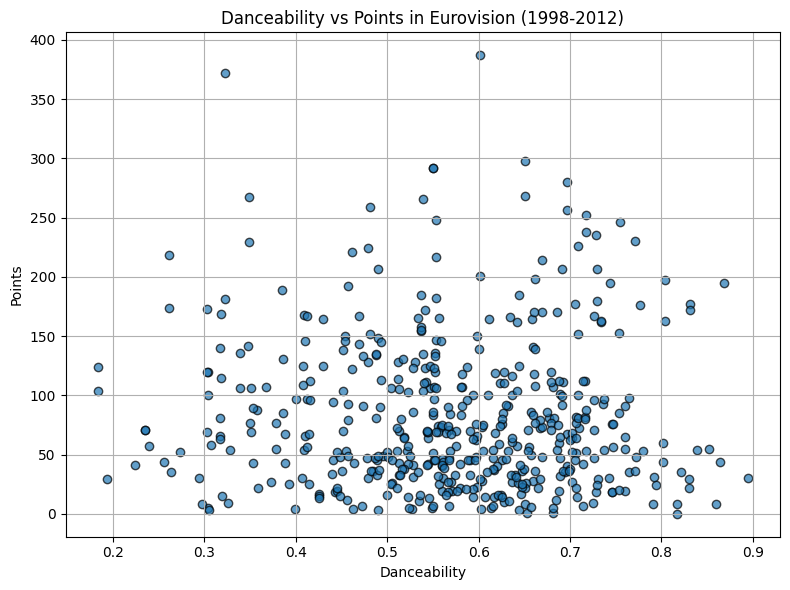

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(df_euro['danceability'], df_euro['Points'], alpha=0.7, edgecolors='k')
plt.title('Danceability vs Points in Eurovision (1998-2012)')
plt.xlabel('Danceability')
plt.ylabel('Points')
plt.grid(True)
plt.tight_layout()
plt.show()

 Based on the plot, where each point
Based on the plot, where each point represents a Eurovision entry’s danceability and the points it earned, the relationship between danceability and points appears weak or not strongly linear. Entries with both low and high danceability values receive a wide range of points, and no clear trend such as "higher danceability means more points" is immediately visible.

Hypothesis:
There is no strong linear relationship between a song’s danceability and the points it receives in the Eurovision Song Contest; other musical, performance, or sociopolitical factors likely play a more significant role in determining the final score.

In [66]:
df_euro = df_euro[['danceability', 'Points']].dropna()

X = df_euro[['danceability']]
y = df_euro['Points']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Gradient Boosting Regressor MAE (using danceability): {mae:.2f}")

Gradient Boosting Regressor MAE (using danceability): 71.67


A lower MAE means your model is more accurate; a higher MAE means it is less accurate. In the competitive environment of Eurovision, a 20-point error can make a significant difference in final rankings. So, MAE gives you a sense of how well your model can estimate the final points using only the "danceability" feature.On average, my model's predicted number of points for each Eurovision entry is off by 20 points (either higher or lower) compared to the actual points received.